In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from keras import datasets

In [2]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    images = images.transpose(0, 2, 3, 1)
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, 1)
    return imgs

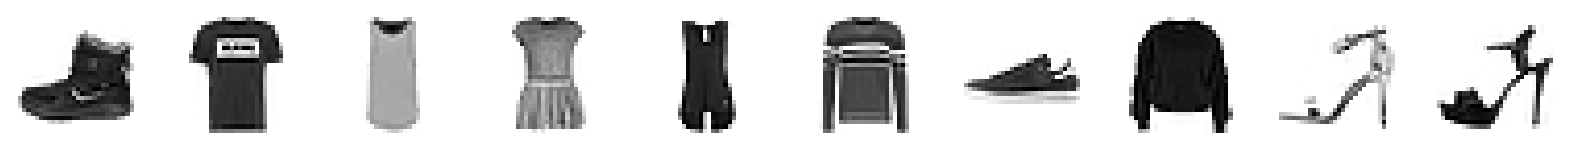

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
x_train = preprocess(x_train)
x_test = preprocess(x_test)
display(x_train)

In [4]:
train_dataset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/tmp/ipykernel_11195/710054519.py:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1724788957849/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  train_dataset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))


In [17]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),  # torch.Size([32, 128, 4, 4])
            nn.Linear(128 * 4 * 4, EMBEDDING_DIM),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(EMBEDDING_DIM, 128 * 4 * 4),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        decoded = self.decoder(x)
        return decoded


class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


encoder = Encoder()
decoder = Decoder()
autoencoder = AutoEncoder(encoder, decoder)


optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

device = "cuda" if torch.cuda.is_available() else "cpu"
autoencoder.to(device)

for epoch in range(EPOCHS):
    for batch_idx, (x_batch, y_batch) in enumerate(train_dataloader):
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        encoded = encoder(x_batch)
        decoded = decoder(encoded)
        loss = loss_fn(decoded, x_batch)
        loss.backward()
        optimizer.step()

In [ ]:
x_sample, y_sample = next(iter(test_dataloader))
autoencoder.eval()
pred = autoencoder(x_sample)

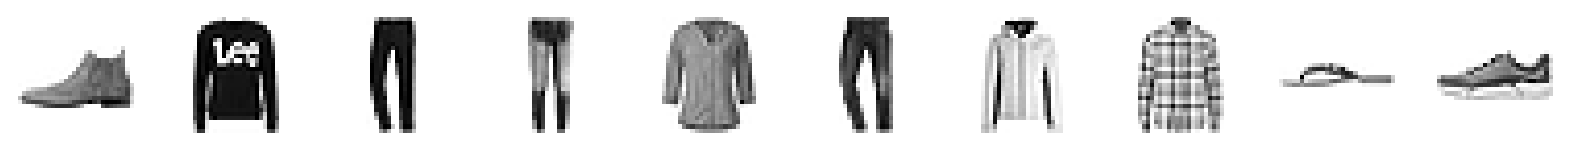

In [30]:
display(x_sample.detach().numpy())

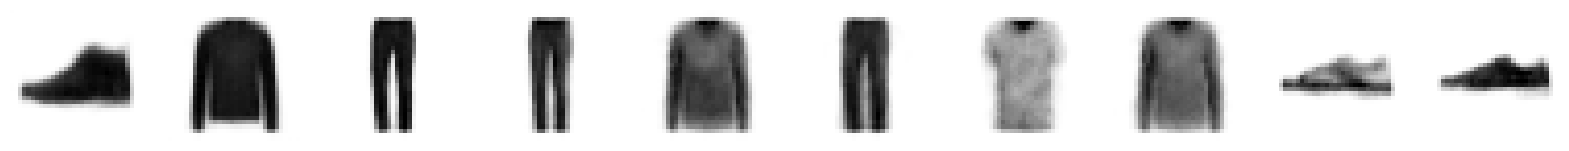

In [26]:
display(pred.detach().numpy())

In [42]:
example_images, sample_labels =test_dataset[:5000]
embeddings = encoder(example_images).detach().numpy()

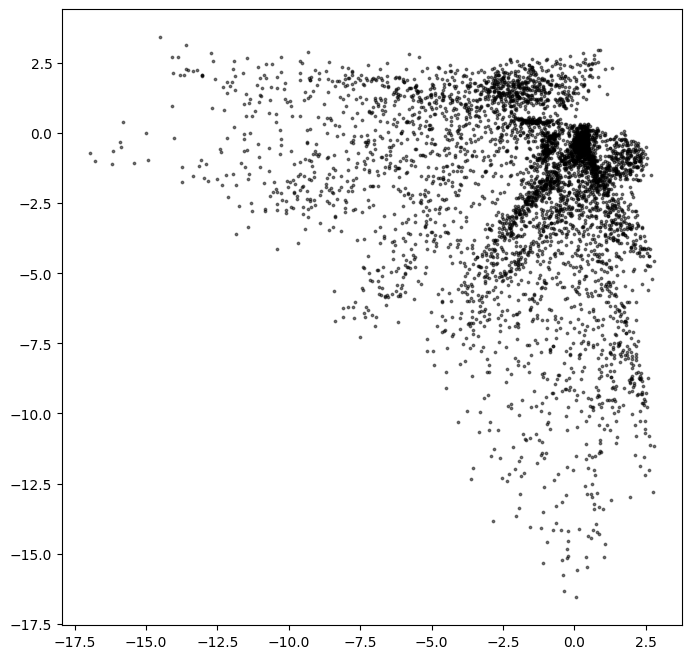

In [43]:
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)


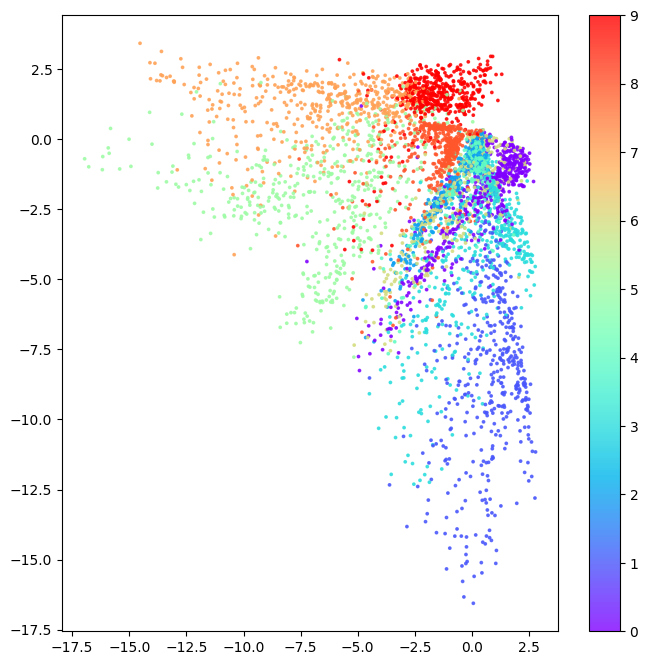

In [44]:
example_labels = y_test[:5000]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()


In [45]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [49]:
reconstructions = decoder(torch.Tensor(sample).to(device)).detach().numpy()

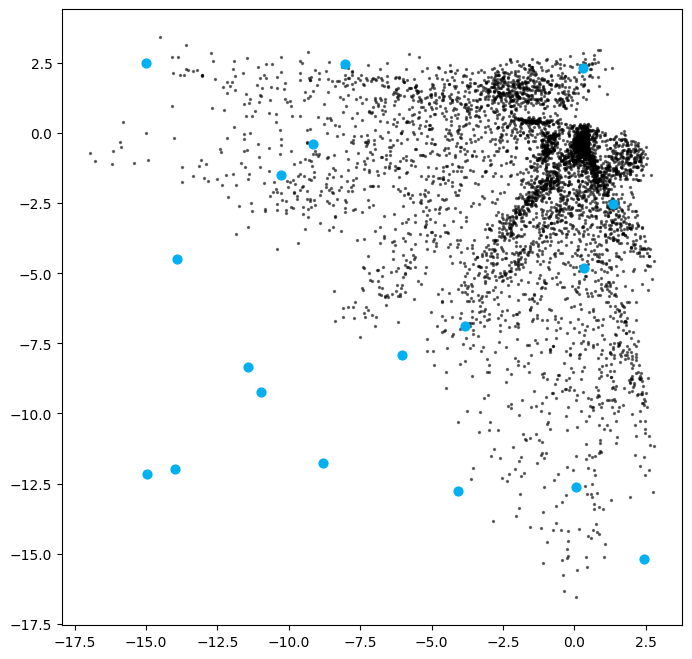

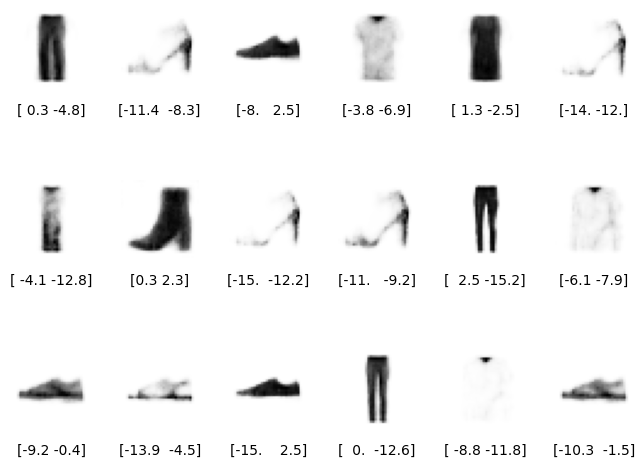

In [51]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(np.transpose(reconstructions[i, :, :], (1, 2, 0)), cmap="Greys")

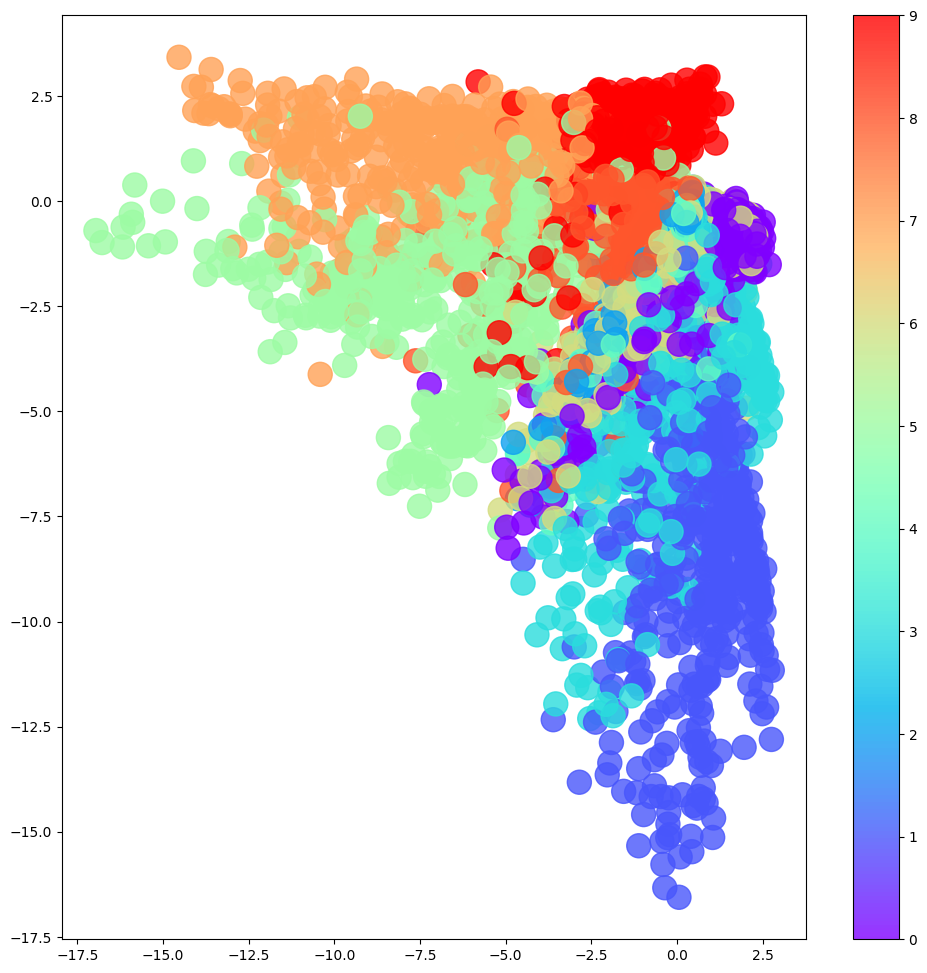

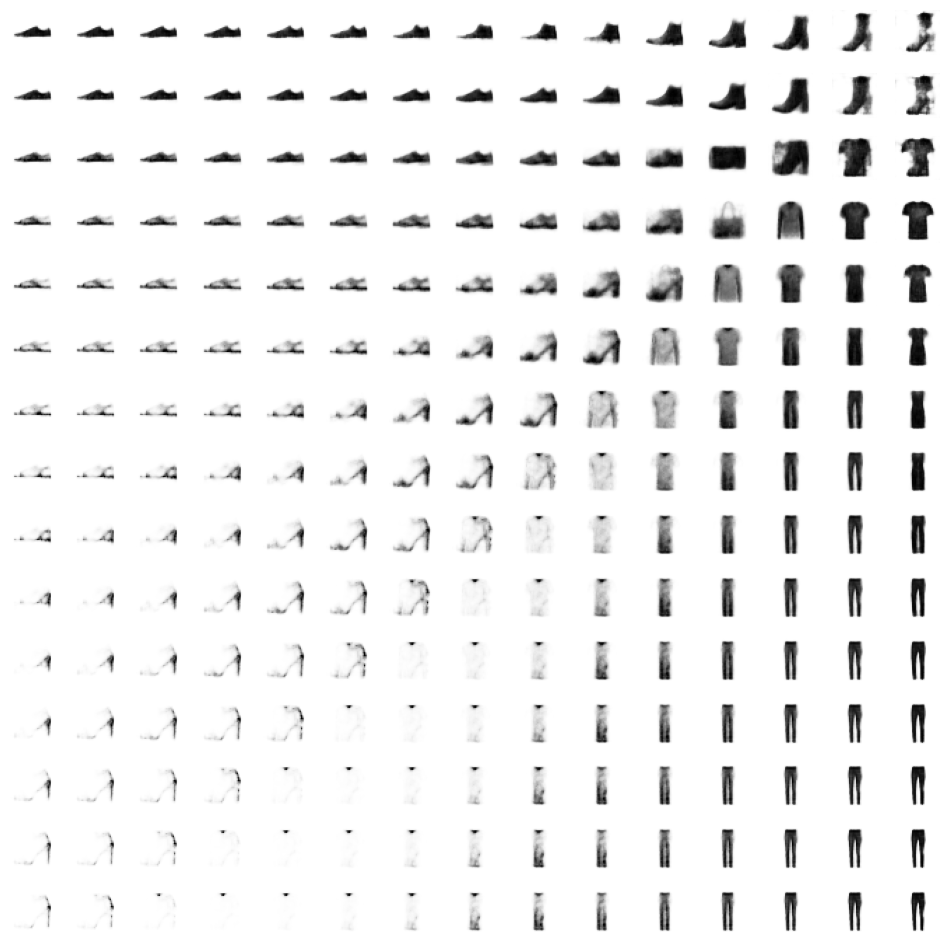

In [55]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder(torch.Tensor(grid)).detach().numpy()
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(np.transpose(reconstructions[i, :, :], (1, 2, 0)), cmap="Greys")